# Flight IFS update

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits


Populating the interactive namespace from numpy and matplotlib


## Load wavecal 

In [26]:
calibname = '/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_660/polychromekeyR50.fits'
lam = fits.open(calibname)[0].data
xindx = fits.open(calibname)[1].data
yindx = fits.open(calibname)[2].data
good = fits.open(calibname)[3].data

In [27]:
print xindx.shape,yindx.shape,good.shape

(18, 108, 108) (18, 108, 108) (18, 108, 108)


In [28]:
print lam

[ 603.64665462  609.78640642  615.98860627  622.25388932  628.58289721
  634.97627808  641.43468668  647.95878442  654.54923942  661.20672661
  667.93192778  674.72553167  681.58823399  688.52073756  695.52375233
  702.59799548  709.74419148  716.96307216]


## Take the 661 nm slice and try to update it with a 660nm monochromatic wavecal image

In [29]:
x = xindx[9]
y = yindx[9]


In [30]:
halfsize=5
snrthreshold=10
apdiam=2

In [31]:
def centroid(img):
    lx,ly = img.shape
    xgrid = np.arange(lx)
    ygrid = np.arange(ly)
    xgrid,ygrid = np.meshgrid(xgrid,ygrid)
    sx = np.sum(xgrid*img)/np.sum(img)
    sy = np.sum(ygrid*img)/np.sum(img)
    return sx,sy

In [32]:
data = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_660/det_655.fits')
ysize, xsize = data.shape
from astropy.stats import sigma_clipped_stats
# mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)
# print mean, median, std
median = np.median(data)
print median
# from photutils import centroid_com as centroid
# from scipy.ndimage import center_of_mass as centroid

10.0


In [33]:
dy = np.zeros_like(y)
dx = np.zeros_like(x)
snr = np.zeros_like(x)
mgrid = np.arange(2*halfsize)
xgrid,ygrid = np.meshgrid(mgrid,mgrid)

for j in range(x.shape[0]):
    for k in range(x.shape[1]):
        if good[9,j,k]:
#         if j == 54 and k == 54:
            xl = x[j,k]
            yl = y[j,k]
            xmin = int(xl-halfsize)+1
            ymin = int(yl-halfsize)+1
            if ymin>0 and xmin>0 and xmin+2*halfsize<xsize and ymin+2*halfsize<ysize:
                # define cutout
                cutout = data[ymin:ymin+2*halfsize,xmin:xmin+2*halfsize]-median
                if j == 54 and k == 54:
                    savecutout = cutout.copy()

                # here is the new centroiding function: we could change this to something more robust
                dx[j,k],dy[j,k] = centroid(cutout)

                # mask used for elementary aperture photometry
                apmask = (xgrid-dx[j,k])**2+(ygrid-dy[j,k])**2<apdiam**2
                apval = np.nansum(apmask*cutout)
    #                             snr[j,k] = apval/(np.sqrt(np.nansum(apmask))*std)

                # estimate of SNR, only valid for very high fluxes, could do better
#                 snr[j,k] = np.sqrt(np.abs(apval))
                snr[j,k] = np.abs(apval)/np.sqrt(np.abs(apval)+median)
                # apply threshold
                if snr[j,k]<snrthreshold:
                    dy[j,k] = np.NaN
                    dx[j,k] = np.NaN
                else:
                    dy[j,k] -= y[j,k]-ymin
                    dx[j,k] -= x[j,k]-xmin
        else:
            snr[j,k] = np.NaN
            dy[j,k] = np.NaN
            dx[j,k] = np.NaN
            
# ignore if new centroid is too out of whack
# dy[np.abs(dy)>2]=np.NaN
# dx[np.abs(dx)>2]=np.NaN

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


mean= -0.856141359052 error= 0.00318560177013
mean= -0.00291102434242 error= 0.00304077148511


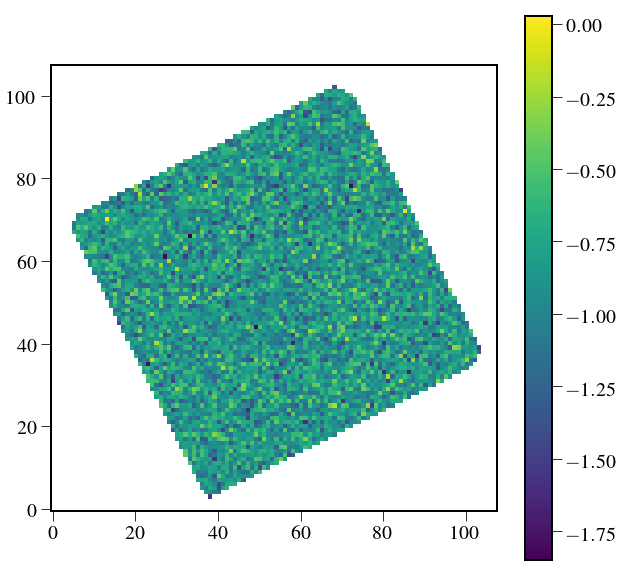

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(dx)
plt.colorbar()
print 'mean=',np.nanmean(dx),"error=",np.nanstd(dx)/np.sqrt(np.sum(~np.isnan(dx)))
print 'mean=',np.nanmean(dy),"error=",np.nanstd(dy)/np.sqrt(np.sum(~np.isnan(dy)))

19.0612102284


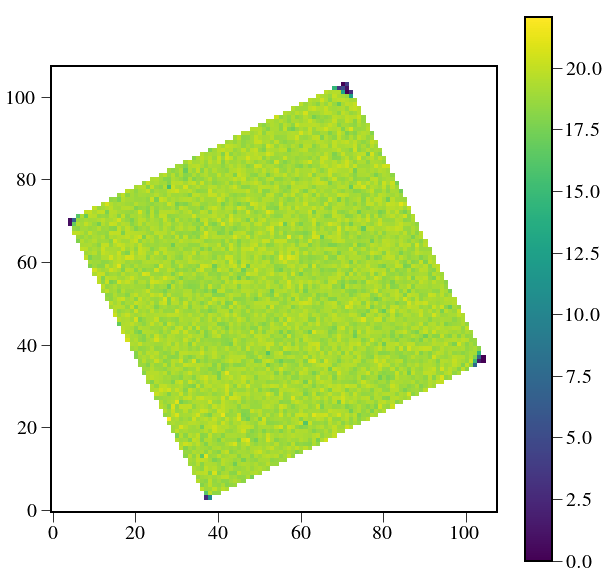

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(snr)
plt.colorbar()
print np.nanmean(snr)

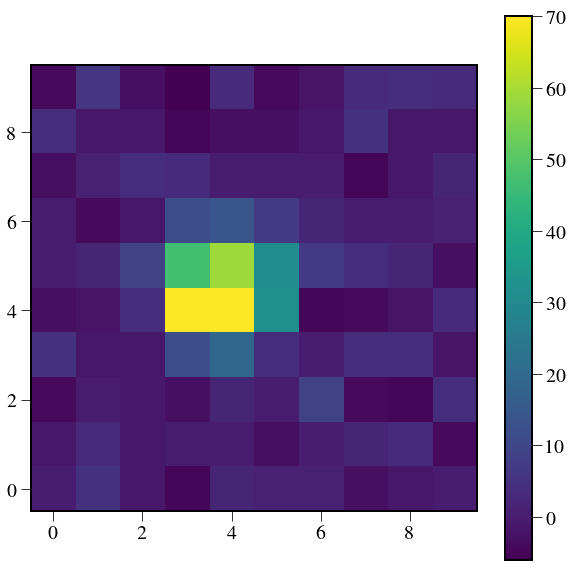

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(savecutout)
plt.colorbar()

(array([   1.,    3.,    1.,    0.,    1.,    2.,    4.,    8.,    7.,
           8.,   21.,   21.,   29.,   32.,   60.,   62.,   78.,  107.,
         130.,  168.,  183.,  235.,  244.,  239.,  329.,  293.,  325.,
         366.,  348.,  327.,  302.,  308.,  262.,  263.,  199.,  178.,
         161.,  101.,   99.,   44.,   47.,   34.,   22.,   19.,    8.,
           8.,    5.,    2.,    0.,    1.,    1.,    1.]),
 array([-1.84908575, -1.81299686, -1.77690796, -1.74081906, -1.70473016,
        -1.66864126, -1.63255236, -1.59646346, -1.56037456, -1.52428566,
        -1.48819676, -1.45210786, -1.41601896, -1.37993006, -1.34384117,
        -1.30775227, -1.27166337, -1.23557447, -1.19948557, -1.16339667,
        -1.12730777, -1.09121887, -1.05512997, -1.01904107, -0.98295217,
        -0.94686327, -0.91077437, -0.87468548, -0.83859658, -0.80250768,
        -0.76641878, -0.73032988, -0.69424098, -0.65815208, -0.62206318,
        -0.58597428, -0.54988538, -0.51379648, -0.47770758, -0.44161868,
  

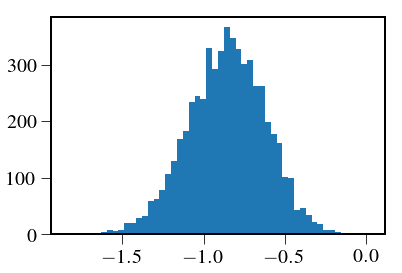

In [37]:
# b,a = np.histogram(dx[~np.isnan(dx)],bins=50)
plt.hist(dx[~np.isnan(dx)], bins='auto') 

## Least squares test

In [38]:
from_pt = []
to_pt = []
for j in range(x.shape[0]):
    for k in range(x.shape[1]):
        if good[9,j,k] and ~np.isnan(x[j,k]) and ~np.isnan(y[j,k]) and ~np.isnan(dx[j,k]) and ~np.isnan(dy[j,k]):
            from_pt.append([x[j,k]-x.shape[0]//2,y[j,k]-y.shape[0]//2])
            to_pt.append([x[j,k]+dx[j,k]-x.shape[0]//2,y[j,k]+dy[j,k]-y.shape[0]//2])

A_data = []
for pt in from_pt:
  A_data.append( [-pt[1], pt[0], 1, 0] )
  A_data.append( [ pt[0], pt[1], 0, 1] )

b_data = []
for pt in to_pt:
  b_data.append(pt[0])
  b_data.append(pt[1])

# Solve
A = np.matrix( A_data )
b = np.matrix( b_data ).T
c,res,rank,sv = np.linalg.lstsq(A, b)
print c
c = np.array(c.T)[0]

print("Solved coefficients:")
print(c)
print np.rad2deg(np.arctan2(c[0],c[1]))*3600,'arcsec'

print np.sqrt(res)

[[  1.14561062e-05]
 [  9.99998312e-01]
 [ -8.50123013e-01]
 [ -7.38918169e-03]]
Solved coefficients:
[  1.14561062e-05   9.99998312e-01  -8.50123013e-01  -7.38918169e-03]
2.36299550421 arcsec
[[ 25.08644391]]


In [39]:
Cinv = np.dot(A.T, A)
C = np.linalg.inv(Cinv)
print Cinv
print C
print np.sqrt(np.diagonal(C)),np.sqrt(1./np.diagonal(Cinv))

[[  3.35773933e+09  -1.25017390e-10  -2.60818119e+06   2.61117723e+06]
 [ -1.25017390e-10   3.35773933e+09   2.61117723e+06   2.60818119e+06]
 [ -2.60818119e+06   2.61117723e+06   5.69700000e+03   0.00000000e+00]
 [  2.61117723e+06   2.60818119e+06   0.00000000e+00   5.69700000e+03]]
[[  1.03427892e-09  -4.37005172e-26   4.73510060e-07  -4.74053985e-07]
 [ -1.00348025e-25   1.03427892e-09  -4.74053985e-07  -4.73510060e-07]
 [  4.73510060e-07  -4.74053985e-07   6.09590837e-04  -1.31162339e-19]
 [ -4.74053985e-07  -4.73510060e-07  -1.76691032e-19   6.09590837e-04]]
[  3.21602070e-05   3.21602070e-05   2.46898934e-02   2.46898934e-02] [  1.72574455e-05   1.72574455e-05   1.32488106e-02   1.32488106e-02]


# Test written software

## First off, need to edit the polychromekey file into a monochromekey file

In [40]:
slicenum=9
fname = '/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_660/polychromekeyR50.fits'
polychrome = fits.open(fname)
print polychrome[1].data[slicenum]

[[  201.42063515   195.4349649    189.44929359 ...,  -427.04104736
   -433.0256791   -439.01028979]
 [  213.39195145   207.40627502   201.42059728 ...,  -415.07172988
   -421.05639376  -427.04103684]
 [  225.36329399   219.37761181   213.39192808 ...,  -403.10234031
   -409.0870359   -415.07171092]
 ..., 
 [ 1458.34021014  1452.35627534  1446.37231353 ...,   829.9190217
    823.93339986   817.94777312]
 [ 1470.30810963  1464.32421451  1458.34029212 ...,   841.88973719
    835.90412907   829.91851579]
 [ 1482.27591668  1476.29206166  1470.30817914 ...,   853.86040608
    847.87481211   841.88921274]]


In [41]:
outkey = fits.HDUList(fits.PrimaryHDU(np.asarray([polychrome[0].data[slicenum]])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[1].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[2].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[3].data[slicenum])))
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/monochromekey_ref.fits', overwrite=True)
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits', overwrite=True)


## Test the software

In [42]:
from update import update,centroid,apply_update

In [43]:
data = fits.getdata('/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits')
monochromekey_file = '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits'

In [ ]:
dx,dy,snr = update(data,monochromekey_file)

In [ ]:
plt.hist(dx[~np.isnan(dx)], bins='auto',label='dx') 
plt.hist(dy[~np.isnan(dy)], bins='auto',label='dy') 
plt.legend()

## Display cutout after shift to make sure it is centered

In [ ]:
j = 54
k = 54
x = monochromekey[1].data
y = monochromekey[2].data
halfsize=5
xl = x[j,k]+dx[j,k]
yl = y[j,k]+dy[j,k]
xmin = int(xl-halfsize)+1
ymin = int(yl-halfsize)+1

cutout = data[ymin:ymin+2*halfsize,xmin:xmin+2*halfsize]



In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cutout)

## Now test the apply update function

[ 516.  517.  518.  519.  520.  521.  522.  523.  524.  525.  526.  527.
  528.  529.  530.  531.  532.  533.  534.  535.  536.  537.] [ 594.20083582  600.23305409  606.31273134  612.44168317  618.62228457
  624.85599686  631.14468988  637.49027476  643.89564076  650.36210433
  656.89185606  663.48786911  670.151413    676.88602889  683.69326674
  690.5759542   697.53731696  704.5794169   711.70527775  718.91802282
  726.22087829  733.61717674]
[ 596.0105013   602.05695727  608.15141689  614.29586359  620.49239826
  626.74260476  633.04836534  639.41188456  645.83557983  652.32102985
  658.87065998  665.48693228  672.17179777  678.92820025  685.75807298
  692.66436302  699.64994694  706.71717516  713.86910127  721.10887946
  728.43976782  735.83606628]


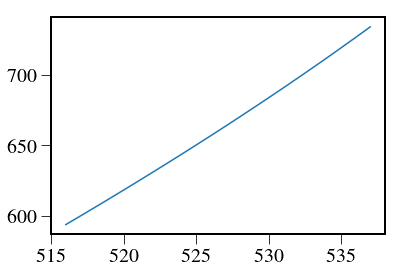

In [190]:
from scipy import interpolate
calib = fits.open('/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
xindx = calib[1].data
yindx = calib[2].data
lams = calib[0].data
nlam = calib[3].data.astype(int)
ix = 54
iy = 54
tck_y = interpolate.splrep(xindx[ix,iy,:nlam[ix,iy]], lams[ix,iy,:nlam[ix,iy]], k=1, s=0)
plt.plot(xindx[ix,iy,:nlam[ix,iy]], lams[ix,iy,:nlam[ix,iy]])
print xindx[ix,iy,:nlam[ix,iy]], lams[ix,iy,:nlam[ix,iy]]
new_lam = interpolate.splev(xindx[ix,iy,:nlam[ix,iy]]+0.3, tck_y)
print new_lam

### Apply only the means of the displacements

In [ ]:
Dx,Dy,sigx,sigy = apply_update(dx,dy,snr,'/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits',None,fitrot=False)

In [ ]:
print Dx,Dy,sigx,sigy

In [ ]:
dx,dy,snr = update(data,monochromekey_file)
plt.hist(dx[~np.isnan(dx)], bins='auto',label='dx') 
plt.hist(dy[~np.isnan(dy)], bins='auto',label='dy') 
plt.legend()

### Use rotation and translation

Reset monochrome

In [ ]:
outkey = fits.HDUList(fits.PrimaryHDU(np.asarray([polychrome[0].data[slicenum]])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[1].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[2].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[3].data[slicenum])))
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits', overwrite=True)


In [ ]:
dx,dy,snr = update(data,'/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits')
plt.hist(dx[~np.isnan(dx)], bins='auto',label='dx') 
plt.hist(dy[~np.isnan(dy)], bins='auto',label='dy') 
plt.legend()

In [ ]:
Dx,Dy,sigx,sigy = apply_update(dx,dy,snr,'/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits',None,fitrot=True)

In [ ]:
plt.imshow(Dy)
plt.colorbar()

In [ ]:
dx,dy,snr = update(data,'/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits')
plt.hist(dx[~np.isnan(dx)], bins='auto',label='dx') 
plt.hist(dy[~np.isnan(dy)], bins='auto',label='dy') 
plt.legend()

# Calibration file

In [2]:
calib_hdus = fits.open('/Users/mrizzo/IFS/crispy-flight/tests/PSFloc.fits')
sigs = fits.open('/Users/mrizzo/IFS/crispy-flight/tests/PSFwidths.fits')
outkey = fits.HDUList(calib_hdus[0])
outkey.append(calib_hdus[1])
outkey.append(calib_hdus[2])
outkey.append(calib_hdus[3])
outkey.append(calib_hdus[4])
outkey.append(sigs[0])
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/calib.fits', overwrite=True)



In [25]:
calib = fits.open('/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
for i in range(6):
    print calib[i].data.shape

(108, 108, 23)
(108, 108, 23)
(108, 108, 23)
(108, 108)
(108, 108)
(108, 108, 23)


# Extraction tests

In [26]:
from extract import extract1D
from astropy.io import fits


In [27]:
slicenum=9
fname = '/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_660/polychromekeyR50.fits'
polychrome = fits.open(fname)
print polychrome[1].data[slicenum]

[[  201.42063515   195.4349649    189.44929359 ...,  -427.04104736
   -433.0256791   -439.01028979]
 [  213.39195145   207.40627502   201.42059728 ...,  -415.07172988
   -421.05639376  -427.04103684]
 [  225.36329399   219.37761181   213.39192808 ...,  -403.10234031
   -409.0870359   -415.07171092]
 ..., 
 [ 1458.34021014  1452.35627534  1446.37231353 ...,   829.9190217
    823.93339986   817.94777312]
 [ 1470.30810963  1464.32421451  1458.34029212 ...,   841.88973719
    835.90412907   829.91851579]
 [ 1482.27591668  1476.29206166  1470.30817914 ...,   853.86040608
    847.87481211   841.88921274]]


In [28]:
outkey = fits.HDUList(fits.PrimaryHDU(np.asarray([polychrome[0].data[slicenum]])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[1].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[2].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[3].data[slicenum])))
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits', overwrite=True)


In [29]:
test660 = '/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits'
img = fits.getdata(test660)
lamlist = np.arange(600,720,5)

In [30]:
cube = extract1D(img,lamlist,'/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
fits.writeto('/Users/mrizzo/IFS/crispy-flight/tests/cube660.fits',cube,overwrite=True)

(5, 23) (5, 23)


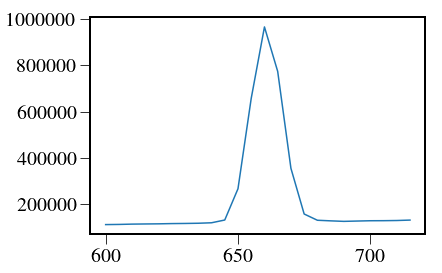

In [31]:
plt.plot(lamlist,np.nansum(np.nansum(cube,axis=2),axis=1))

In [32]:
from scipy.optimize import curve_fit
def gauss(x, a, x0, sig,b):
    return b+a*np.exp(-(x-x0)**2/(2.*sig**2))

vals = np.nansum(np.nansum(cube,axis=2),axis=1)
popt, pcov = curve_fit(gauss, lamlist, 
            vals,
            p0=[np.amax(vals),lamlist[np.argmax(vals)],5,0])
print popt[1]
# evaluate arrays
curve_vals = gauss(lamlist, *popt)


660.697877935


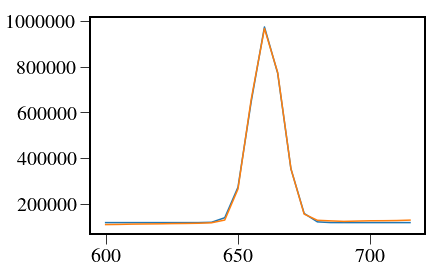

In [33]:
plt.plot(lamlist,curve_vals)
plt.plot(lamlist,vals)


## Test the extraction - update cycle

1. Extract 660 cube with normal wavecal and save; find the peak (should be around 660)
2. Update wavecal with 655 cube, faking an overall wavecal shift
3. Extract 655 cube and save; find the peak (should STILL be around 660)
4. Extract 660 cube and save; find the peak (should be around 665)

In [34]:
from update import update,centroid,apply_update

In [35]:
data = fits.getdata('/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits')
monochromekey_file = '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits'
cube = extract1D(data,lamlist,'/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
vals = np.nansum(np.nansum(cube,axis=2),axis=1)
popt, pcov = curve_fit(gauss, lamlist, 
            vals,
            p0=[np.amax(vals),lamlist[np.argmax(vals)],5,0])
print popt[1]


(5, 23) (5, 23)
660.697877935


In [36]:
dx,dy,snr = update(data,monochromekey_file)

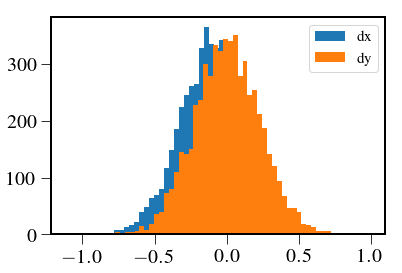

In [37]:
plt.hist(dx[~np.isnan(dx)], bins='auto',label='dx') 
plt.hist(dy[~np.isnan(dy)], bins='auto',label='dy') 
plt.legend()

In [38]:
print np.nanmean(dx),np.nanmean(dy)

-0.0891413156501 0.00370488557676


In [39]:
Dx,Dy,sigx,sigy = apply_update(dx,#-0.1*np.ones_like(dx,dtype=np.float),
                               dy,#0.0*np.ones_like(dy,dtype=np.float),
                               snr,
                               '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits',
                               '/Users/mrizzo/IFS/crispy-flight/tests/calib.fits',
                               fitrot=True)

(3.4565562807569687e-06, 0.99999642346758966, -0.08920779057963199, 0.0037235979142099833)


In [40]:
calib = fits.open('/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
for i in range(6):
    print calib[i].data.shape

(108, 108, 23)
(108, 108, 23)
(108, 108, 23)
(108, 108)
(108, 108)
(108, 108, 23)


In [41]:
test660 = '/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits'
img = fits.getdata(test660)
lamlist = np.arange(600,720,5)
cube = extract1D(img,lamlist,'/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
fits.writeto('/Users/mrizzo/IFS/crispy-flight/tests/cube660_after_shift.fits',cube,overwrite=True)

(5, 23) (5, 23)


660.111735221


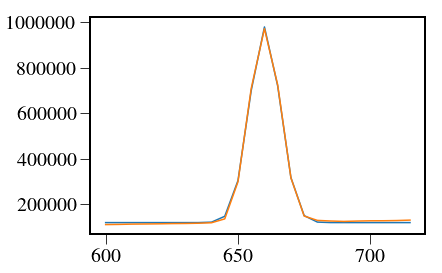

In [42]:
vals = np.nansum(np.nansum(cube,axis=2),axis=1)
popt, pcov = curve_fit(gauss, lamlist, 
            vals,
            p0=[np.amax(vals),lamlist[np.argmax(vals)],5,0])
print popt[1]
curve_vals = gauss(lamlist, *popt)
plt.plot(lamlist,curve_vals)
plt.plot(lamlist,vals)


In [43]:
test655 = '/Users/mrizzo/IFS/crispy-flight/tests/det_655.fits'
img = fits.getdata(test655)
lamlist = np.arange(600,720,5)

In [44]:
ncube = extract1D(img,lamlist,'/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')
fits.writeto('/Users/mrizzo/IFS/crispy-flight/tests/cube655.fits',cube,overwrite=True)

(5, 23) (5, 23)


In [45]:
vals = np.nansum(np.nansum(ncube,axis=2),axis=1)
npopt, pcov = curve_fit(gauss, lamlist, 
            vals,
            p0=[np.amax(vals),lamlist[np.argmax(vals)],5,0])
print npopt[1]


655.114393732


# Create new files instead of overriding calibration file

## Extraction step

In [3]:

from extract import extract1D


In [4]:
slicenum=9
fname = '/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_660/polychromekeyR50.fits'
polychrome = fits.open(fname)


In [5]:
outkey = fits.HDUList(fits.PrimaryHDU(np.asarray([polychrome[0].data[slicenum]])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[1].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[2].data[slicenum])))
outkey.append(fits.PrimaryHDU(np.asarray(polychrome[3].data[slicenum])))
outkey.writeto('/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits', overwrite=True)


In [6]:
test660 = '/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits'
img = fits.getdata(test660)
lamlist = np.arange(600,720,5)

In [7]:
cube = extract1D(img,lamlist,'/Users/mrizzo/IFS/crispy-flight/tests/calib.fits')

(5, 23) (5, 23)


In [8]:
from unittests import fit_monochromatic_cube,plotfit
print fit_monochromatic_cube(cube,lamlist)

660.697877935


660.697877935


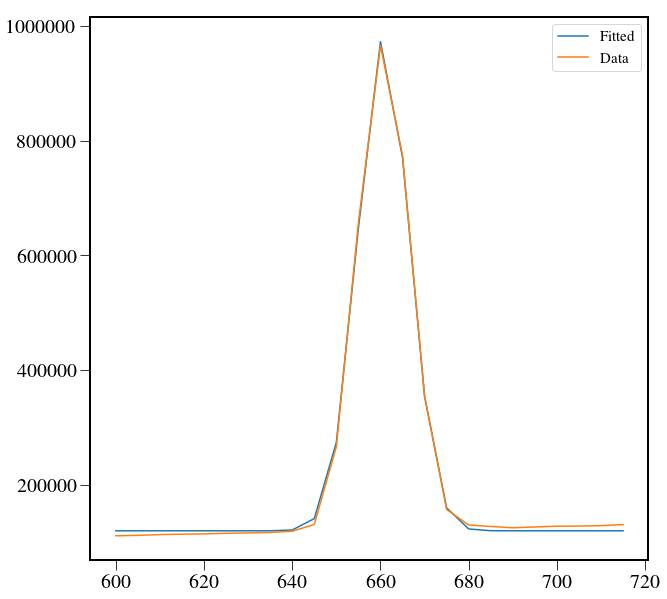

In [9]:
plotfit(cube,lamlist)

## Update

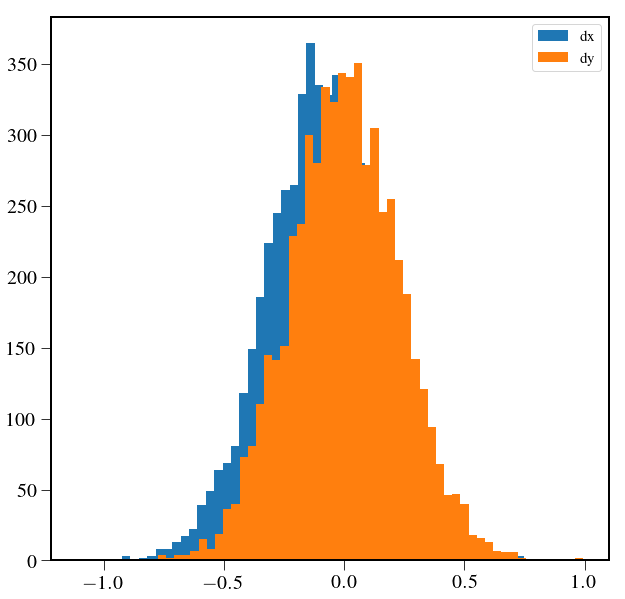

In [10]:
from update import update,apply_update
data = fits.getdata('/Users/mrizzo/IFS/crispy-flight/tests/det_660.fits')
monochromekey_file = '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits'

dx,dy,snr = update(data,monochromekey_file)

from unittests import histograms
histograms(dx,dy)

In [11]:
import time
tstring = time.strftime("%Y%m%d-%H%M%S")
newmono = '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey_'+tstring+'.fits'
newcalib = '/Users/mrizzo/IFS/crispy-flight/tests/newcalib_'+tstring+'.fits'

Dx,Dy,sigx,sigy = apply_update(dx,#-1.1*np.ones_like(dx,dtype=np.float),
                               dy,#0.0*np.ones_like(dy,dtype=np.float),
                               snr,
                               '/Users/mrizzo/IFS/crispy-flight/tests/monochromekey.fits',
                               '/Users/mrizzo/IFS/crispy-flight/tests/calib.fits',
                               newmono,
                               newcalib,
                               fitrot=True)

('s,c,tx,ty:', 3.621103998721923e-06, 0.99999593465515224, -1.100073533638521, 0.003722391800916657)
Created /Users/mrizzo/IFS/crispy-flight/tests/monochromekey_20180822-225957.fits
Created /Users/mrizzo/IFS/crispy-flight/tests/newcalib_20180822-225957.fits


(5, 23) (5, 23)
666.684054142


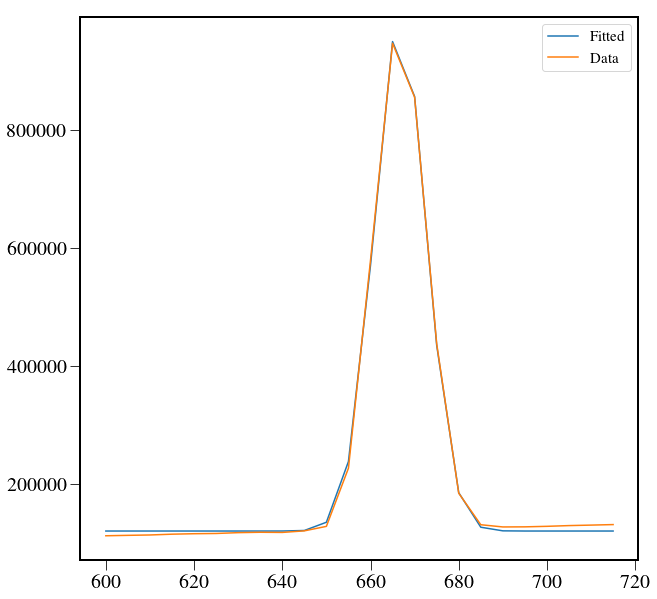

In [12]:
cube = extract1D(img,lamlist,newcalib)
plotfit(cube,lamlist)